[Hanane Dupouy](https://www.linkedin.com/in/hanane-d-algo-trader)

In this tutorial, the goal is to compare 3 of the most important LLMs (closed source) and analyse their capabilities of extracting data from complex Financial charts (Financial Report Analysis from JPMorgan 2022).

In this notebook different calls are made to Anthropic and OpenAI APIs.
We are comparing these following Multimodal LLMs:

*   claude-3-5-sonnet-20240620
*   claude-3-opus-20240229
*   gpt-4o

This comes with costs charged by the APIs.

# Install Lib

In [2]:
!pip install anthropic -q
!pip install openai -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.5/863.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.6/327.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 5.4 MB/s eta 0:00:00


# Get API Keys

In [3]:
from google.colab import userdata
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

import openai
openai.api_key = OPENAI_API_KEY

import anthropic

# PDF loading

## Monting drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
local_path='LocalPath'
path_pdf = local_path + 'jpmorgan_annualreport-2022-splitted.pdf'
output_directory_path = local_path+'/test_claude'

Mounted at /content/drive


In [6]:
%pip install PyMuPDF -q
import fitz
from PIL import Image
import io
import base64
import matplotlib.pyplot as plt
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 23.1 MB/s eta 0:00:00


I already converted the pdf pages to images ==> I'm using one of the images:

In [ ]:
output_directory_path = local_path+'test_claude'
images = [Image.open(f"{output_directory_path}/page_1.png")]
    # Close the PDF document
# doc.close()

base64_encoded_pngs = []
quality=75
max_size=(1024, 1024)
for image in images:
        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)
        image_data = io.BytesIO()
        image.save(image_data, format='PNG', optimize=True, quality=quality)
        image_data.seek(0)
        base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
        base64_encoded_pngs.append(base64_encoded)

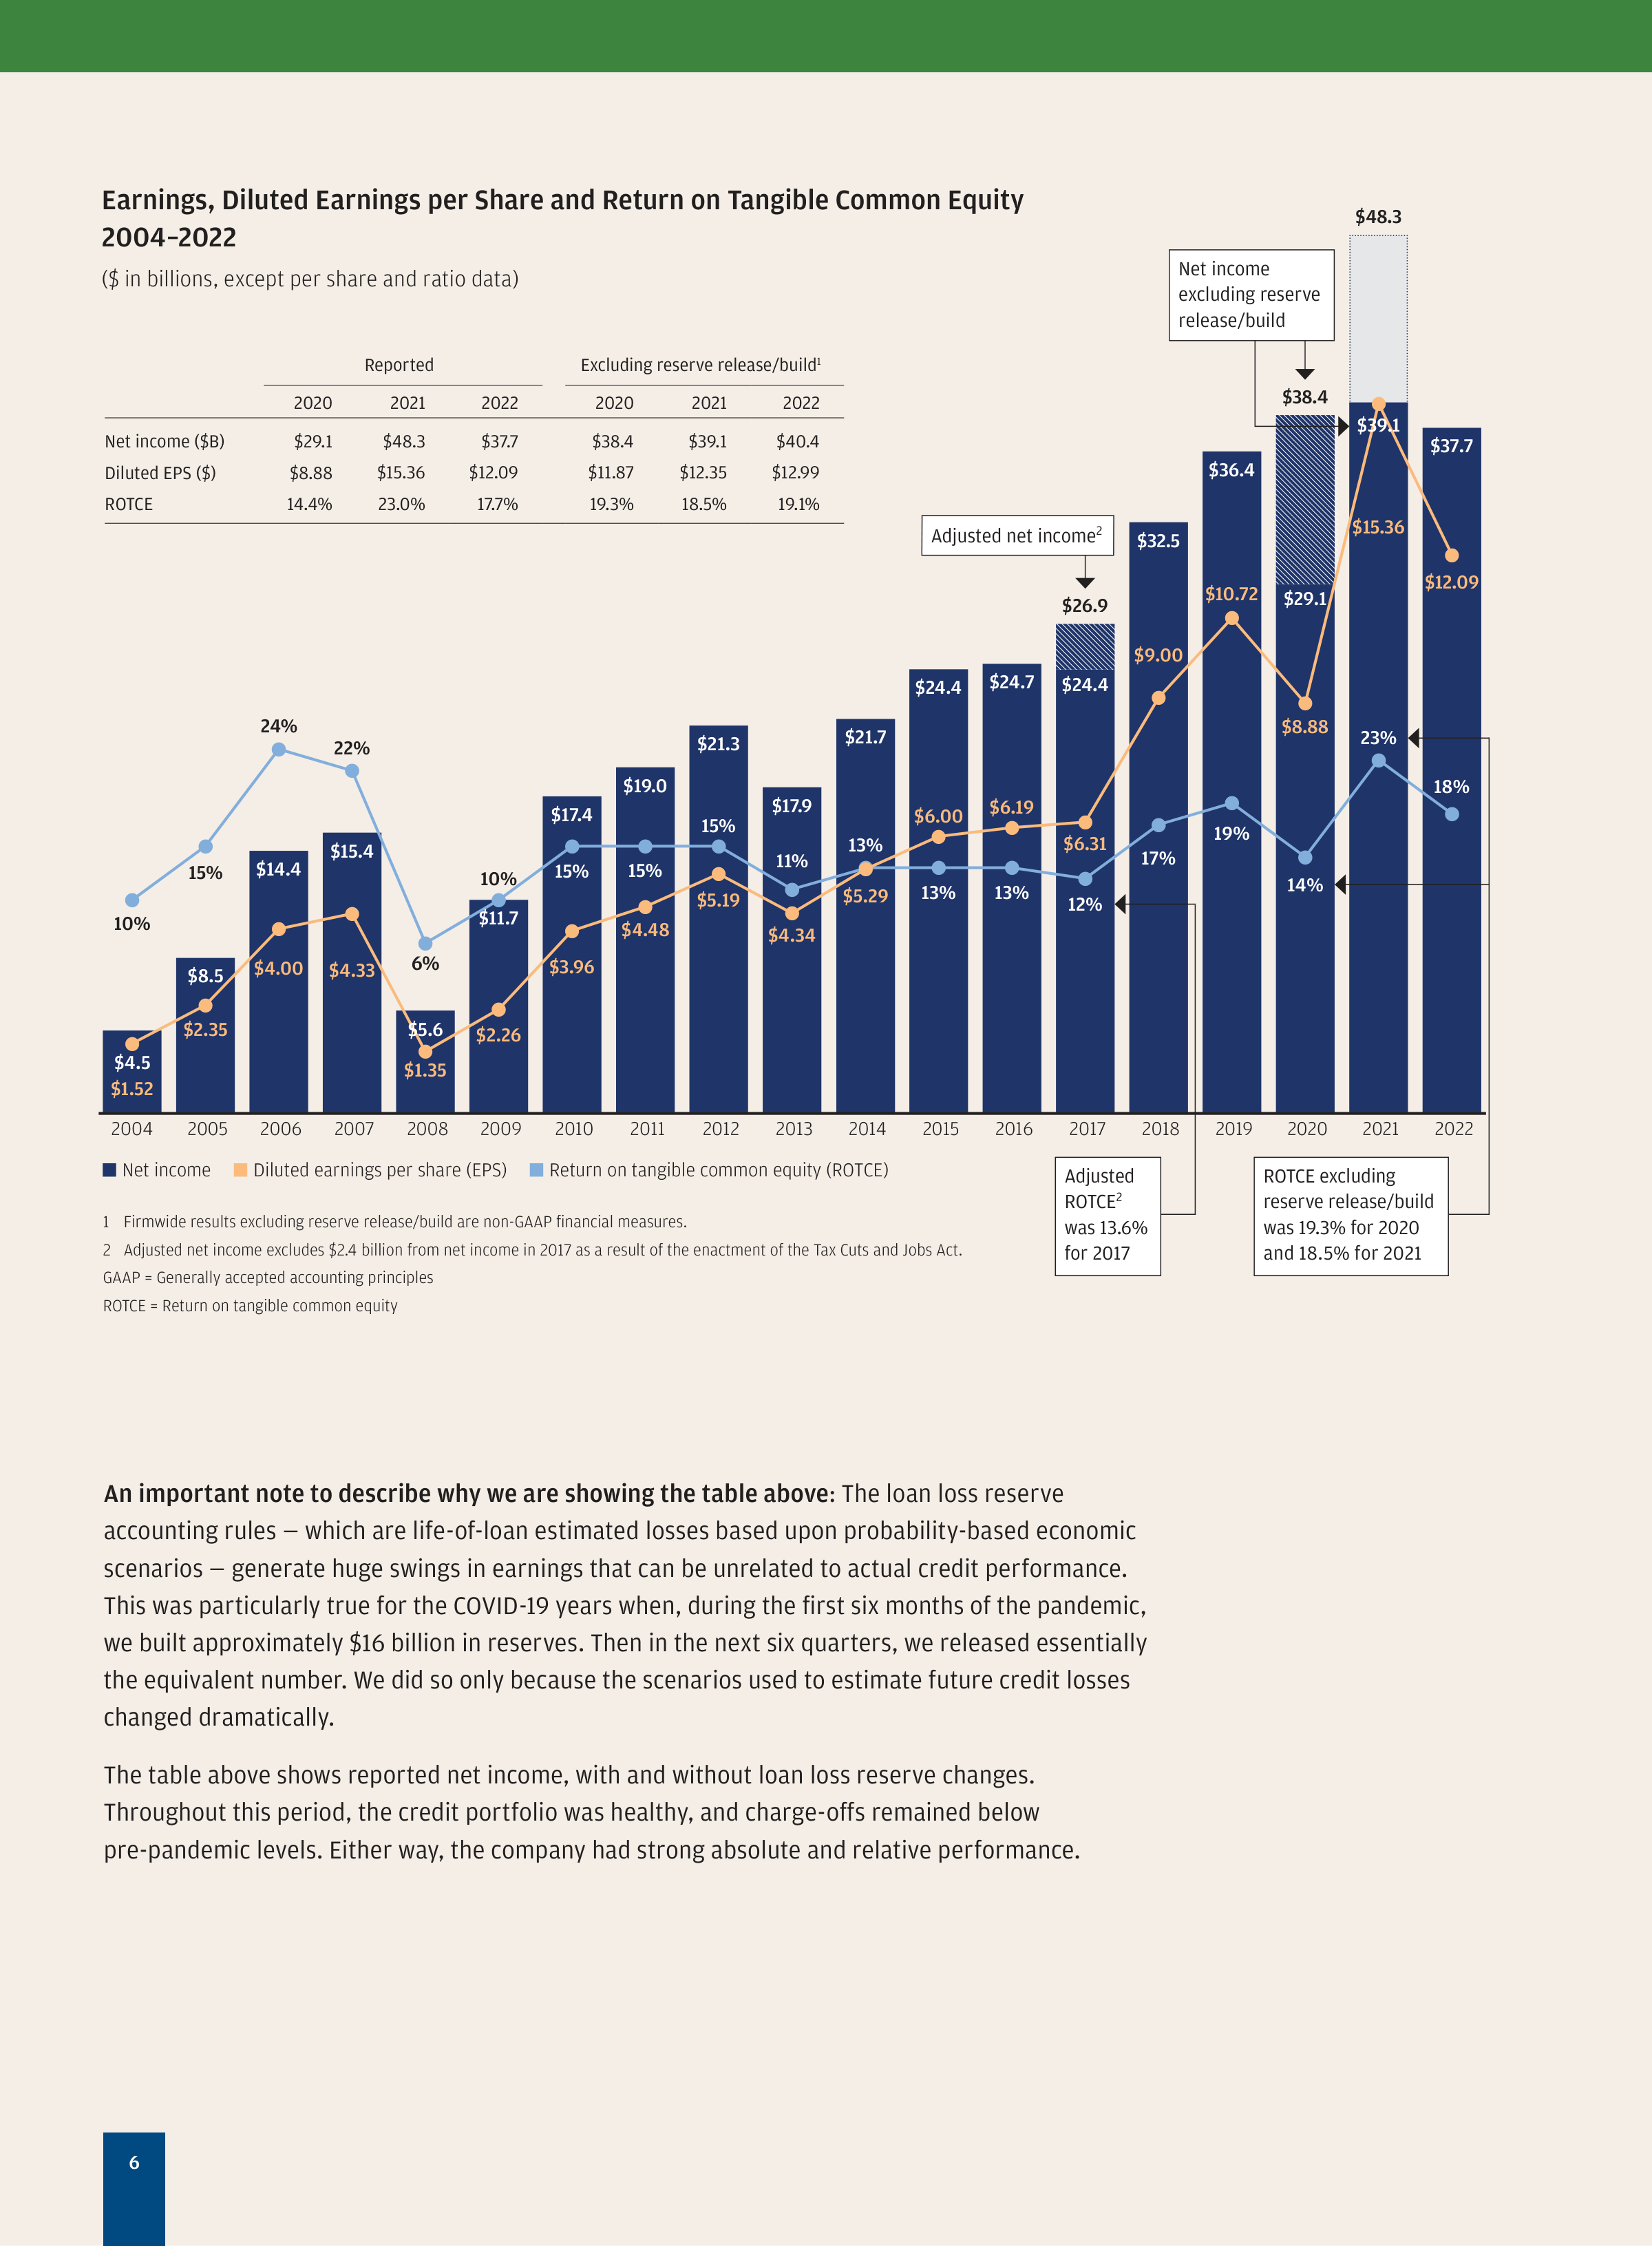

In [53]:
path_img = f"{output_directory_path}/page_1.png"

from IPython.display import Image
Image(path_img)

In [11]:
# ## If you want to Convert your PDF pages to images
# output_directory_path = local_path+'test_claude'

# doc = fitz.open(local_path+"jpmorgan_annualreport-2022-splitted.pdf")

# # Iterate through each page of the PDF
# for page_num in range(doc.page_count):
#         # Load the page
#         page = doc.load_page(page_num)

#         # Render the page as a PNG image
#         pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))

#         # Save the PNG image
#         output_path = f"{output_directory_path}/page_{page_num+1}.png"
#         pix.save(output_path)

# # Convert the PNG images to base64 encoded strings
# images = [Image.open(f"{output_directory_path}/page_{page_num+1}.png") for page_num in range(doc.page_count)]
#     # Close the PDF document
# doc.close()

# base64_encoded_pngs = []
# quality=75
# max_size=(1024, 1024)
# for image in images:
#         # Resize the image if it exceeds the maximum size
#         if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
#             image.thumbnail(max_size, Image.Resampling.LANCZOS)
#         image_data = io.BytesIO()
#         image.save(image_data, format='PNG', optimize=True, quality=quality)
#         image_data.seek(0)
#         base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
#         base64_encoded_pngs.append(base64_encoded)

# Calling Claude 3.5

In [22]:
client_claude = anthropic.Anthropic(
    api_key=CLAUDE_API_KEY,
)

# MODEL_NAME = "claude-3-opus-20240229"
MODEL_NAME = "claude-3-5-sonnet-20240620"
def get_completion_claude(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=2048,
        temperature=0,
        messages=messages
    )
    return response.content[0].text

In [29]:
def get_message_content(question, encoded_pngs):
  content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
  content1 = {"type": "text", "text": question}
  content.append(content1)

  messages = {"role": 'user',"content": content}

  return messages


## Prompt: Extract all data included in the images

$\color{pink}{\text{This prompt will instruct Claude 3.5 to extract all data it's seeing in the chart (loaded as an image) as a markdown}}$ $\color{pink}{\text{==>}}$ $\color{blue}{\text{Claude 3.5 is extracting the exact values from this complicated chart}}$ $\color{blue}{\text{which is very interesting and takes the LLM to another level of precision}}$

$\color{purple}{\text{Have a closer look on the year 2014 where the Diluted EPS and the ROTCE are overlaped in the graph,}}$ $\color{purple}{\text{and even with this, Claude 3.5 extracted the exact values from the chart}}$

In [30]:
# encoded_pngs = base64_encoded_pngs

question = """
    Load the charts data from the image and output it in a markdown format .
    Try your best to extract the charts data from the image.
    If you can't extract the chart data, please summarize the image and return the summary.
"""
messages = get_message_content(question, base64_encoded_pngs)
messages

{'role': 'user',
 'content': [{'type': 'image',
   'source': {'type': 'base64',
    'media_type': 'image/png',
    'data': 'iVBORw0KGgoAAAANSUhEUgAAAvEAAAQACAIAAADnRJEwAAEAAElEQVR42uydd3gVRduHZ7bvnpLee0IKhN47SFPsDUHFgoi9d9TX3n3tSJUmvffeIRB6h0ACpPd+yvbd+f5YcowB/Xw1KuLcl3JtztkzOzs7s/ObZ555Bvb5oC/AYDAYDAaD+YdD4CLAYDAYDAaDNQ0Gg8FgMBgM1jQYDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGaxoMBoPBYDAYrGkwGAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgM1jQYDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYrGkwGAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgMFjTYDAYDAaDwVyEghDiUsBgMBgMBvOP1zSaruFSwGAwGAwG84/XNCGOYFwKGAwGg8Fg/unAmop8XAoYDAaDwWD+6VAczeFSwGAwGAwG84/XNAYycClgMBgMBoP5x2saCPC6JwwGg8FgMP94cHwaDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgMFjTYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYLCmwWAwGAwGgzUNBoPB

In [23]:
all_messages = [messages]
chart_analysis = get_completion_claude(all_messages)
print(chart_analysis)

Here's the data from the chart in markdown format:

| Year | Net Income ($B) | Diluted EPS ($) | Return on Tangible Common Equity (ROTCE) |
|------|-----------------|-----------------|------------------------------------------|
| 2004 | 4.5             | 1.52            | 10%                                      |
| 2005 | 8.5             | 2.35            | 15%                                      |
| 2006 | 14.0            | 4.00            | 24%                                      |
| 2007 | 14.3            | 4.33            | 22%                                      |
| 2008 | 5.6             | 1.35            | 6%                                       |
| 2009 | 11.7            | 2.26            | 10%                                      |
| 2010 | 17.4            | 3.96            | 15%                                      |
| 2011 | 19.0            | 4.48            | 15%                                      |
| 2012 | 21.3            | 5.19            | 15%                    

$\color{purple}{\text{Here, I asked different questions. Overall, we get correct results }}$

In [41]:
question = "What was the Net Income in 2012?"
messages = get_message_content(question, base64_encoded_pngs)
print(messages)
print(get_completion_claude([messages]))

{'role': 'user', 'content': [{'type': 'image', 'source': {'type': 'base64', 'media_type': 'image/png', 'data': 'iVBORw0KGgoAAAANSUhEUgAAAvEAAAQACAIAAADnRJEwAAEAAElEQVR42uydd3gVRduHZ7bvnpLee0IKhN47SFPsDUHFgoi9d9TX3n3tSJUmvffeIRB6h0ACpPd+yvbd+f5YcowB/Xw1KuLcl3JtztkzOzs7s/ObZ555Bvb5oC/AYDAYDAaD+YdD4CLAYDAYDAaDNQ0Gg8FgMBgM1jQYDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGaxoMBoPBYDAYrGkwGAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgM1jQYDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYrGkwGAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgMFjTYDAYDAaDwVyEghDiUsBgMBgMBvOP1zSaruFSwGAwGAwG84/XNCGOYFwKGAwGg8Fg/unAmop8XAoYDAaDwWD+6VAczeFSwGAwGAwG84/XNAYycClgMBgMBoP5x2saCPC6JwwGg8FgMP94cHwaDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgMFjTYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYLCmwWAwGAwGgzUNBoPBYDAYDNY0GAwG

In [42]:
# content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
question = "What are the : 1/Diluted Earnings per Share in 2014 and 2/ the Return on Tangible Common Equity on 2017?"
messages = get_message_content(question, base64_encoded_pngs)
print(messages)
print(get_completion_claude([messages]))

{'role': 'user', 'content': [{'type': 'image', 'source': {'type': 'base64', 'media_type': 'image/png', 'data': 'iVBORw0KGgoAAAANSUhEUgAAAvEAAAQACAIAAADnRJEwAAEAAElEQVR42uydd3gVRduHZ7bvnpLee0IKhN47SFPsDUHFgoi9d9TX3n3tSJUmvffeIRB6h0ACpPd+yvbd+f5YcowB/Xw1KuLcl3JtztkzOzs7s/ObZ555Bvb5oC/AYDAYDAaD+YdD4CLAYDAYDAaDNQ0Gg8FgMBgM1jQYDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGaxoMBoPBYDAYrGkwGAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgM1jQYDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYrGkwGAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgMFjTYDAYDAaDwVyEghDiUsBgMBgMBvOP1zSaruFSwGAwGAwG84/XNCGOYFwKGAwGg8Fg/unAmop8XAoYDAaDwWD+6VAczeFSwGAwGAwG84/XNAYycClgMBgMBoP5x2saCPC6JwwGg8FgMP94cHwaDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgMFjTYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYLCmwWAwGAwGgzUNBoPBYDAYDNY0GAwG

$\color{purple}{\text{==> The value of EPS in 2014 is not correct ==> 5.29 instead of 6.}}$
$\color{purple}{\text{==> What we need to do now, is to 1/Append the new message with the first answer with the markdown values.}}$

$\color{purple}{\text{2/Send back these answer to the LLM along side the image, and 3/see what happens:
}}$

## Append the message with the first answer with the markdown data

In [40]:
llm_answer = {"role": 'assistant',"content": chart_analysis}
all_messages.append(llm_answer)

question2 = "What are the : 1/Diluted Earnings per Share in 2014 and 2/ the Return on Tangible Common Equity on 2017?"
messages2 = get_message_content(question2, base64_encoded_pngs)

all_messages.append(messages2)
all_messages

[{'role': 'user',
  'content': [{'type': 'image',
    'source': {'type': 'base64',
     'media_type': 'image/png',
     'data': 'iVBORw0KGgoAAAANSUhEUgAAAvEAAAQACAIAAADnRJEwAAEAAElEQVR42uydd3gVRduHZ7bvnpLee0IKhN47SFPsDUHFgoi9d9TX3n3tSJUmvffeIRB6h0ACpPd+yvbd+f5YcowB/Xw1KuLcl3JtztkzOzs7s/ObZ555Bvb5oC/AYDAYDAaD+YdD4CLAYDAYDAaDNQ0Gg8FgMBgM1jQYDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGaxoMBoPBYDAYrGkwGAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgM1jQYDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYrGkwGAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgMFjTYDAYDAaDwVyEghDiUsBgMBgMBvOP1zSaruFSwGAwGAwG84/XNCGOYFwKGAwGg8Fg/unAmop8XAoYDAaDwWD+6VAczeFSwGAwGAwG84/XNAYycClgMBgMBoP5x2saCPC6JwwGg8FgMP94cHwaDAaDwWAwWNNgMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgsKbBYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYE2DwWAwGAwGgzUNBoPBYDAYDNY0GAwGg8FgMFjTYDAYDAaDwZoGg8FgMBgMBmsaDAaDwWAwGKxpMBgMBoPBYLCmwWAwGAwGgzU

In [37]:
llm_completion = get_completion_claude(all_messages)
print(llm_completion)

Based on the chart in the image:

1. The Diluted Earnings per Share (EPS) in 2014 was $5.29

2. The Return on Tangible Common Equity (ROTCE) in 2017 was 12%


$\color{purple}{\text{Now we get the exact value for EPS in 2014. (ROTCE for 2017 was already ok)
}}$

## Trying other questions

In [43]:
questions = [
             "What was the Net Income in 2007?",
             "What was the Return on Tangible Common Equity (ROTCE) in 2007?",
             "What was the Diluted Earnings per Share in 2007?"
             ]
for question in questions:
    messages = get_message_content(question, base64_encoded_pngs)
    print(f"Question:{question}")
    print("AI answer:")
    print(get_completion_claude([messages]))
    print("*"*50)
    print("\n")

Question:What was the Net Income in 2007?
AI answer:
According to the chart, the Net Income for 2007 was $4.33 billion.
**************************************************


Question:What was the Return on Tangible Common Equity (ROTCE) in 2007?
AI answer:
According to the chart, the Return on Tangible Common Equity (ROTCE) for 2007 was 22%.
**************************************************


Question:What was the Diluted Earnings per Share in 2007?
AI answer:
According to the chart, the Diluted Earnings per Share (EPS) in 2007 was $4.33.
**************************************************




All OK

# Calling Claude 3

In [44]:
MODEL_NAME = "claude-3-opus-20240229"
# MODEL_NAME = "claude-3-5-sonnet-20240620"
def get_completion_claude3(messages):
    response = client_claude.messages.create(
        model=MODEL_NAME,
        max_tokens=2048,
        temperature=0,
        messages=messages
    )
    return response.content[0].text

In [45]:
# encoded_pngs = base64_encoded_pngs

question = """
    Load the charts data from the image and output it in a markdown format .
    Try your best to extract the charts data from the image.
    If you can't extract the chart data, please summarize the image and return the summary.
"""
messages = get_message_content(question, base64_encoded_pngs)

all_messages = [messages]
chart_analysis = get_completion_claude3(all_messages)
print(chart_analysis)

| Year | Net Income | Diluted EPS ($) | ROTCE |
|------|------------|----------------|-------|
| 2004 | $4.5       | $2.43          | 15%   |
| 2005 | $8.5       | $4.00          | 19%   |
| 2006 | $14.4      | $6.00          | 24%   |
| 2007 | $15.4      | $4.33          | 22%   |
| 2008 | $5.6       | $1.35          | 10%   |
| 2009 | $11.7      | $2.26          | 10%   |
| 2010 | $17.4      | $3.96          | 15%   |
| 2011 | $18.9      | $4.48          | 16%   |
| 2012 | $21.3      | $5.20          | 18%   |
| 2013 | $17.9      | $4.35          | 11%   |
| 2014 | $21.7      | $5.29          | 13%   |
| 2015 | $24.4      | $6.00          | 13%   |
| 2016 | $24.7      | $6.19          | 13%   |
| 2017 | $24.4      | $6.31          | 12%   |
| 2018 | $32.5      | $9.00          | 17%   |
| 2019 | $36.4      | $10.72         | 19%   |
| 2020 | $29.1      | $8.88          | 14%   |
| 2021 | $48.3      | $15.36         | 23%   |
| 2022 | $37.7      | $12.09         | 18%   |

The image s

$\color{purple}{\text{If you compare the outputs of Claude 3 Opus vs Claude 3.5 Opus
, }}$ $\color{purple}{\text{you'll see that Claude 3 has retrieved wrong information, it's even more visible for ROTCE. However Claude 3.5 gets the exact values!}}$

# GPT-4o

In [46]:
from openai import OpenAI

client_openai = OpenAI(api_key=OPENAI_API_KEY)
MODEL_NAME_GPT = "gpt-4o"

def get_completion_gpt4o(messages):
    response = client_openai.chat.completions.create(
        model=MODEL_NAME_GPT,
        # max_tokens=2048,
        temperature=0,
        messages=messages
    )
    print(response.model)
    return response.choices[0].message.content

In [50]:
def get_message_content_openai(question, encoded_pngs):
  # content = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": encoded_png}} for encoded_png in encoded_pngs]
  content = [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_png}"}} for encoded_png in encoded_pngs]
  content1 = {"type": "text", "text": question}
  content.append(content1)

  messages = {"role": 'user',"content": content}

  return messages

{'role': 'user',
 'content': [{'type': 'image_url',
   'image_url': {'url': ''}},
  {'type': 'text',
   'text': "\n    Load the charts data from the image and output it in a markdown format .\n    Try your best to extract the charts data from the image.\n    If you can't extract the chart data, please summarize the image and return the summary.\n"}]}
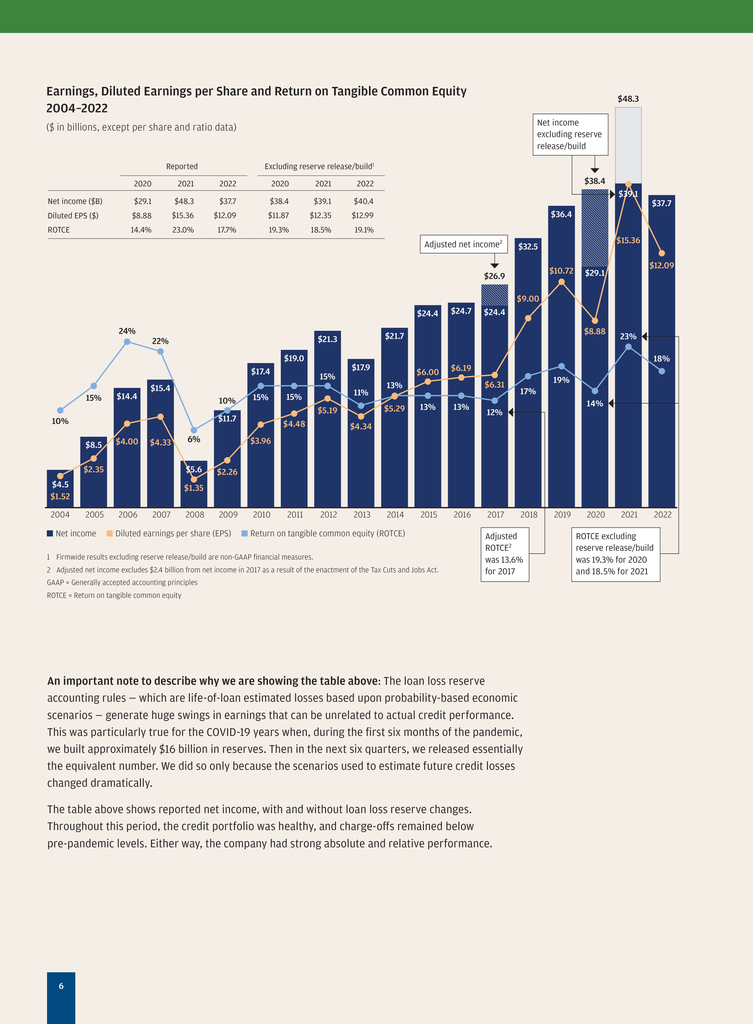

In [51]:
question = """
    Load the charts data from the image and output it in a markdown format .
    Try your best to extract the charts data from the image.
    If you can't extract the chart data, please summarize the image and return the summary.
"""
messages = get_message_content_openai(question, base64_encoded_pngs)
messages

In [52]:
gpt4o_completion = get_completion_gpt4o([messages])
print(gpt4o_completion)

gpt-4o-2024-05-13
Here is the data extracted from the image in markdown format:

### Earnings, Diluted Earnings per Share and Return on Tangible Common Equity 2004-2022
($ in billions, except per share and ratio data)

#### Reported
| Year | Net Income ($B) | Diluted EPS ($) | ROTCE (%) |
|------|-----------------|-----------------|-----------|
| 2020 | $29.1           | $8.88           | 14.4%     |
| 2021 | $48.3           | $15.36          | 23.0%     |
| 2022 | $37.7           | $12.09          | 17.7%     |

#### Excluding reserve release/build
| Year | Net Income ($B) | Diluted EPS ($) | ROTCE (%) |
|------|-----------------|-----------------|-----------|
| 2020 | $38.4           | $11.87          | 19.3%     |
| 2021 | $39.1           | $12.35          | 18.5%     |
| 2022 | $40.4           | $12.99          | 19.1%     |

### Net Income, Diluted Earnings per Share (EPS), and Return on Tangible Common Equity (ROTCE) Over the Years
| Year | Net Income ($B) | Diluted EPS ($) | ROT

$\color{purple}{\text{Even if GPT-4o succedd to collect the table data (whereas Claude 3.5 avoid to do it for "simplicity")}}$ $\color{purple}{\text{The values extracted from the chart are not correct, especially for the first years (like Claude 3) and for ROTCE.}}$
$\color{purple}{\text{So, we see the same behavior between Claude 3 and GPT-4o.}}$